# 2017-09-09 Mitigating the wrapping of deltas in BaSTi synthetic populations #

wiclarks@umich.edu - started 2017-09-09

**Purpose:** Develop and test a simple (ad hoc) strategy to characterize synthetic stellar population $\Delta M$~in the presence of possible imposition of a hard limit and wrapping.

# 1. Results and indications #

(To be included when done.)

# 2. Plan #

Assuming some 1D sample-set $x$~is drawn from a symmetric underlying distribution, so that the mean $\langle x \rangle$~and median $x_m$~can be expected to roughly coincide in a sample with $N$~objects, the sample variance $\epsilon^2$~can be estimated following
\begin{eqnarray}
    \epsilon^2 & \equiv & \frac{1}{N-1}\sum^{\rm all}_{i=1} \left( x_i - \langle x \rangle \right)^2 \\
    & \approx & \frac{1}{N-1} \left[ \sum^{\lt x_m}_i \left( x_i - x_m \right)^2 
    + \sum^{\ge x_m}_i \left( x_i - x_m \right)^2 \right] \\
    & \simeq & \frac{2}{N-1} \sum^{\lt x_m}_i \left( x_i - x_m \right)^2~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(1)
\end{eqnarray}

Where for the final line we assume that $N(\lt x_m) \approx N(\ge x_m)$ and that the two samples above and below $x_m$ are similar in magnitude.

If we insist that $N(\lt x_m) = N(\ge x_m) = N/2$, and also (equivalently?) that $N$ is large, then we have

\begin{eqnarray}
    \epsilon^2 & \approx & \frac{1}{N(< x_m)} \sum^{\lt x_m}_i \left( x_i - x_m \right)^2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(2) 
\end{eqnarray}

where the median $x_m$ must be determined by some other method than taking the median of our now one-sided sample. In the applications I have in mind, $N$~will typically be in the hundreds; i.e. $N-1 \approx N$, etc.

(This must be a standard result, I don't have my stats books to hand just this moment...)

Steps to produce the estimate:
1. Classify objects into those "impacted" by the boundary condition, and otherwise, possibly using external information;
2. Estimate the median $x_m$~of the underlying distribution, allowing for censored data;
3. Identify the objects on the same side of $x_m$~as the majority of the non-"impacted" points;
4. Estimate $\epsilon^2$~following expression (1) above.

The tricky part is likely going to be estimating $x_m$ with censored data, since there is no guarantee that (say) a single Gaussian will describe the data. I adopt the ad-hoc approach of fitting a Gaussian to the histogram of the deltas selected.

The specific use-case is to examine $\Delta M$ from sequences fit to BaSTi synthetic stellar populations. Several aspects (e.g. the data to use when working out what's censored) come across with these particular data tables. Hopefully it's obvious how to generalize this.

# 3. Setup #

### 3.1. Python modules ###

In [1]:
# import a few needed things
from astropy.table import Table, Column
import os
import numpy as np


In [2]:
# the fitter we will use to find the peak
from scipy.optimize import curve_fit

In [3]:
# for plotting
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
# use snazzy styles / allow light-colored scatter-points to be visible?
plt.style.use('ggplot')

### 3.2. Location of datafiles ###

In [5]:
dirDeltas = './outputs'

# 4. Define methods #

In [6]:
def f_gauss1d(x, mean, sigma, norm):
    
    """1D gaussian"""
    
    powr = 0.5 * ((x - mean)/sigma)**2
    cons = norm * 1.0 / (sigma * np.sqrt(2.0 * np.pi))
    
    return cons * np.exp(0. - powr)

In [7]:
def findVarianceSymm(tDeltas, limitColumn='fehSel', valuColumn='deltaMag', \
                    nBins=30, nBinsFit=25, isoSet='ss', \
                    printDispersions=True, \
                    limitValues = {'ss':[-2.27, 0.40], 'al':[-2.67, 0.05]}, \
                    showFigure=False, \
                    alphaAvoid = 0.7, \
                    showExclude=True, \
                    sLabelLim=r'[Fe/H]', \
                     sTitle='', \
                    asFlux=False, \
                    Verbose=True):
    
    """Method that wraps the cell-by-cell analysis we did in v1 of this notebook"""
    
    # We could come back and refactor this into methods later... for the moment 
    # let's stick with this laundry list to avoid passing arguments back and forth.
    
    # find objects that are near a boundary
    bLo = tDeltas[limitColumn] < limitValues[isoSet][0]
    bHi = tDeltas[limitColumn] >= limitValues[isoSet][-1]
    bOK = (~bLo) & (~bHi)
    
    # Produce the pieces we'll need to compute and draw the histogram
    vDeltas = tDeltas[valuColumn]
    
    if asFlux:
        vDeltas = 2.512**vDeltas
    
    xRange = [np.min(vDeltas), np.max(vDeltas)]
    
    # compare the mean and median to decide which "bad" case we have here
    xMed = np.median(vDeltas)
    xMean = np.mean(vDeltas)
    usingHi = True
    if xMed < xMean:
        bBad = np.copy(bHi)
        usingHi=True
        iNudge = 1
    else:
        bBad = np.copy(bLo)
        usingHi=False
        iNudge = -1
        
    # compute the histogram, find the argmax and the object next to it
    histBad, edgesBad = np.histogram(vDeltas[bBad], bins=nBins, range=xRange)

    iBig = np.argmax(histBad)
    limUpperBad = edgesBad[iBig+iNudge]

    # now that we have our limit, this time compute the histogram of the "OK" values
    
    if usingHi:
        bToFit = (bOK) & (vDeltas > limUpperBad)
    else:
        bToFit = (bOK) & (vDeltas < limUpperBad)
        
    # allow a different binning for this histogram!
    histFit, edgesFit = np.histogram(vDeltas[bToFit], nBinsFit)
    medsFit = 0.5 * (edgesFit[0:-1] + edgesFit[1::])
    histFit = np.array(histFit, 'float')
    
    # now try a fit using curve_fit. Construct guess parameters
    guess = np.array([np.median(vDeltas[bToFit]), np.std(vDeltas[bToFit]), np.max(histFit) ])
    bounds = ([xRange[0], 0., 0.], [xRange[1], xRange[1]-xRange[0], np.max(histFit)*5.])

    popt, pcov = curve_fit(f_gauss1d, medsFit, histFit,\
                           p0=guess, \
                          bounds=bounds)

    if Verbose:
        print "INFO - Gaussian fit:", popt
    
    # now find the variance of the points in the half we're using
    if usingHi:
        bForStat = (bOK) & (vDeltas > popt[0])
    else:
        bForStat = (bOK) & (vDeltas < popt[0])
    
    varOnesided = np.sum( (vDeltas[bForStat] - popt[0])**2 ) / np.float(np.sum(bOK)-1.0)

    # or, we could just use our one-sided samples directly
    varHalf = np.sum( (vDeltas[bForStat] - popt[0])**2 ) / np.float(np.sum(bForStat))
    
    if printDispersions:
        print "INFO - expression (1):  %.3f" % (np.sqrt(varOnesided * 2.0))
        print "INFO - expression (2):  %.3f" % (np.sqrt(varHalf))
        print "INFO - Gaussian approx: %.3f" % (popt[1])
    
    if showFigure:
        # set up the figure
        fig1 = plt.figure(1, figsize=(12,7))
        fig1.clf()

        # some labels
        sLabelX = r'$\Delta M$'
        if asFlux:
            sLabelX = r'$2.512^{\Delta M}$'
        
        sLabelY = r'N(%s)' % (sLabelX)

        # set up for the stacked histogram
        lLabels = ['%s Between limits' % (sLabelLim), '%s outside range' % (sLabelLim)]
        lColos = ['g', 'm']
        
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(2,2,2, sharex=ax1)
        ax3 = fig1.add_subplot(2,2,4, sharex=ax1)

        # try stacked histogram
        vStack = [vDeltas[bOK], vDeltas[bBad]]
        
        nAll, binsAll, patchesAll = \
            ax1.hist(vStack, nBins, range=xRange, alpha=0.5, color=lColos, stacked=True, \
                     zorder=5, label=lLabels, rwidth=1.)
#            ax1.hist(vDeltas, nBins, range=xRange, alpha=0.5, color='0.1', \
#                    stacked=True, label='Entire sample', zorder=5)
    
        nOK, binsOK, patchesOK = \
            ax2.hist(vDeltas[bOK], nBins, range=xRange, alpha=0.5, color=lColos[0], \
                     label=lLabels[0], zorder=5)
        nHi, binsHi, patchesHi = \
            ax3.hist(vDeltas[bBad], nBins, range=xRange, alpha=0.5, \
                     color=lColos[1], label=lLabels[1], zorder=5)
            
        if showExclude:
            for thisAx in [ax2, ax3]:
                xRang2 = np.copy(thisAx.get_xlim())
                yRang2 = np.copy(thisAx.get_ylim())

                # ensure there's room for the legend (not sure why this isn't working)
                yRang2[-1] += 40
                
                # the limits depend on which direction we're going.
                polY2 = np.array([yRang2[0], yRang2[0], yRang2[1], yRang2[1], yRang2[0]])
                if usingHi:
                    polX2 = np.array([xRang2[0], limUpperBad, limUpperBad, xRang2[0], xRang2[0]])            
                else:
                    polX2 = np.array([limUpperBad, xRang2[-1], xRang2[-1], limUpperBad, limUpperBad])

                thisAx.fill(polX2, polY2, color='0.7', alpha=alphaAvoid, zorder=1)
                thisAx.plot(polX2, polY2, color='0.1', alpha=0.9, zorder=15, ls='--', lw=2)
                thisAx.set_xlim(xRang2)
                thisAx.set_ylim(yRang2)

                
        # if it's been fit, overplot our fitted distribution
        xSet = np.copy(ax2.get_xlim())
        xFine = np.linspace(xSet[0], xSet[-1], 1000)
        dumShow = ax2.plot(xFine, f_gauss1d(xFine, *popt) * float(nBinsFit)/float(nBins), \
                           lw=4, color='b', alpha=0.5, label='Smooth fit')
                
        for axX in [ax1, ax3]:
            axX.set_xlabel(sLabelX)
        for thisAxis in [ax1, ax2, ax3]:
            legThis = thisAxis.legend(frameon=True)
            legThis.get_frame().set_facecolor('w')
            legThis.set_zorder(55)
    
            thisAxis.set_ylabel(sLabelY)
    
        if len(sTitle) > 0:
            sSet = ''
            if isoSet.find('al') > -1:
                sSet = r'$\alpha$-enhanced'
            if isoSet.find('ss') > -1:
                sSet = r'scaled-to-Solar'

            if len(sSet) > 0:
                sSet = ': [Fe/H] limits assume %s' % (sSet)
                
            titlString = '%s%s' %(sTitle, sSet)
            fig1.suptitle(titlString)
    
    return varHalf
    

In [8]:
def wrapGetStd(filDeltas='testMetRich_deltas.fits', isoSet='ss', asFlux=False):
    
    """Convenient one-liner to do the analysis"""
    
    tDeltas = Table()
    pathDeltas = '%s/%s' % (dirDeltas, filDeltas)
    if not os.access(pathDeltas, os.R_OK):
        print "WARN - cannot access input path %s" % (pathDeltas)
        return
        
    tDeltas = Table.read(pathDeltas)
    varHalf = findVarianceSymm(tDeltas, isoSet=isoSet, showFigure=True, \
                              sTitle=filDeltas, asFlux=asFlux)
    
    return np.sqrt(varHalf)
    

# 5. Do the analyses #

In [9]:
filDeltas = 'testMetRich_deltas.fits'
isoSet = 'ss'

# try the halo metal-poor
#filDeltas = 'haloMetalPoor_deltas.fits'
# isoSet = 'al'

INFO - Gaussian fit: [  3.06094312e-03   1.19256460e-01   3.48190603e+01]
INFO - expression (1):  0.141
INFO - expression (2):  0.131
INFO - Gaussian approx: 0.119


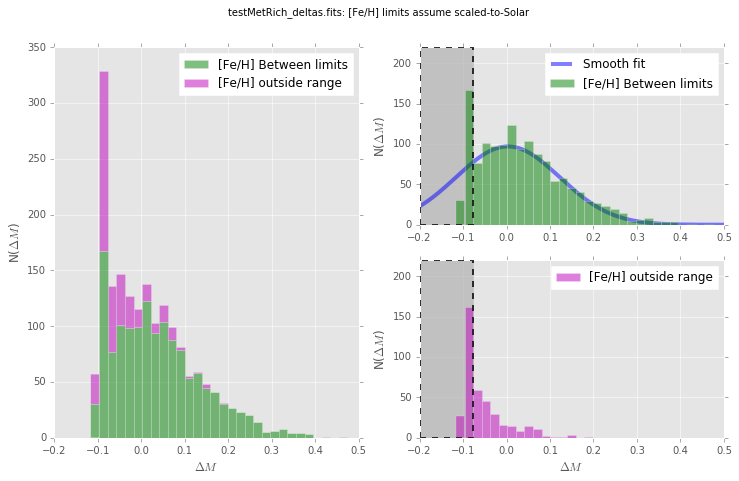

In [10]:
stdHalf = wrapGetStd(filDeltas, isoSet=isoSet, asFlux=False)

INFO - Gaussian fit: [  8.81424536e-03   1.58367880e-01   1.23565474e+02]
INFO - expression (1):  0.155
INFO - expression (2):  0.152
INFO - Gaussian approx: 0.158


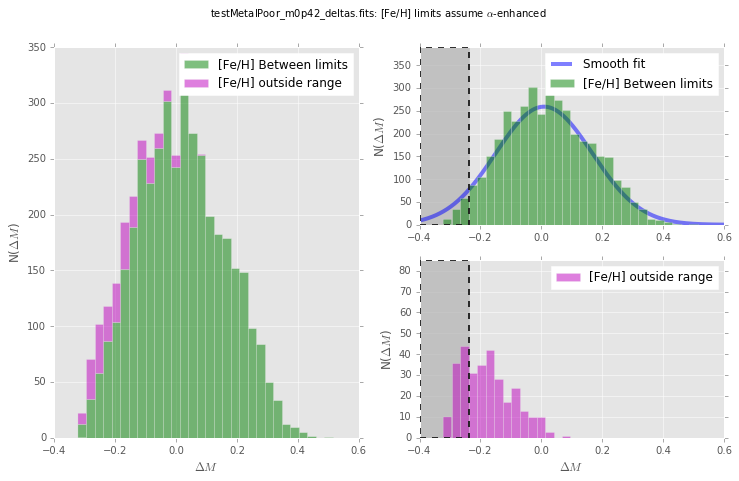

In [11]:
# try our "well-behaved" metal-poor population
#filDeltasMP = 'testMetalPoor_m0p77_deltas.fits'
filDeltasMP = 'testMetalPoor_m0p42_deltas.fits'
isoSetMP = 'al'
stdHalfMP = wrapGetStd(filDeltasMP, isoSet=isoSetMP, asFlux=False)

In [12]:
print "%.3f" % (np.sqrt(stdHalfMP**2 - stdHalf**2))

0.077
